# 🚚 Olist Delivery Time Prediction (Tuned XGBoost)

## 🎯 Objective
Predict `actual_delivery_days` with optimized hyperparameters.

## ⚙️ Methodology
1.  **Data Loading & Split**: Strict time-based split (Past -> Future).
2.  **Hyperparameter Tuning**: Use `RandomizedSearchCV` to find the best configuration.
3.  **Final Model**: Train on full training set with best params.
4.  **Evaluation**: RMSE, MAE, and Business Impact.

In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import xgboost
    print(f"XGBoost Version: {xgboost.__version__}")
except ImportError:
    !pip install xgboost
    import xgboost

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

XGBoost Version: 3.1.3


## 1. Load & Prepare Data

In [10]:
df = pd.read_csv("olist_processed.csv")

# Ensure rows are sorted by time
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df = df.sort_values('order_purchase_timestamp').reset_index(drop=True)

features = [
    'price', 'freight_value', 'product_weight_g', 'product_volume_cm3', 
    'distance_km', 'is_same_state',
    'purchase_year', 'purchase_month', 'purchase_weekday',
    'estimated_delivery_days'
]
target = 'actual_delivery_days'

# Time-Based Split (80/20)
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

print(f"Train Size: {X_train.shape}")
print(f"Test Size:  {X_test.shape}")

Train Size: (87444, 10)
Test Size:  (21861, 10)


## 2. Hyperparameter Tuning (RandomizedSearchCV)
We use `TimeSeriesSplit` for cross-validation to respect the temporal order during tuning.

In [11]:
# Define Parameter Grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Base Estimator
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Search Strategy
tscv = TimeSeriesSplit(n_splits=3)
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    n_iter=20,          # Try 20 random combinations
    scoring='neg_mean_absolute_error', # Optimize for MAE
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("Starting Hyperparameter Tuning...")
random_search.fit(X_train, y_train)

print(f"\n✅ Best Parameters: {random_search.best_params_}")
print(f"Best CV Score (Negative MAE): {random_search.best_score_:.4f}")

Starting Hyperparameter Tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Best Parameters: {'subsample': 0.7, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Best CV Score (Negative MAE): -5.5992


## 3. Final Model Evaluation

In [12]:
best_model = random_search.best_estimator_
preds = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)

print("\n--- 🏆 Final Test Set Results ---")
print(f"RMSE: {rmse:.4f} days")
print(f"MAE:  {mae:.4f} days")

# Baseline Comparison
baseline_preds = test_df['estimated_delivery_days']
baseline_mae = mean_absolute_error(y_test, baseline_preds)

print(f"\nBaseline (Olist Estimate) MAE: {baseline_mae:.4f} days")
print(f"Improvement: {((baseline_mae - mae) / baseline_mae * 100):.2f}%")


--- 🏆 Final Test Set Results ---
RMSE: 5.7783 days
MAE:  4.7057 days

Baseline (Olist Estimate) MAE: 13.3292 days
Improvement: 64.70%


## 4. Residual Analysis

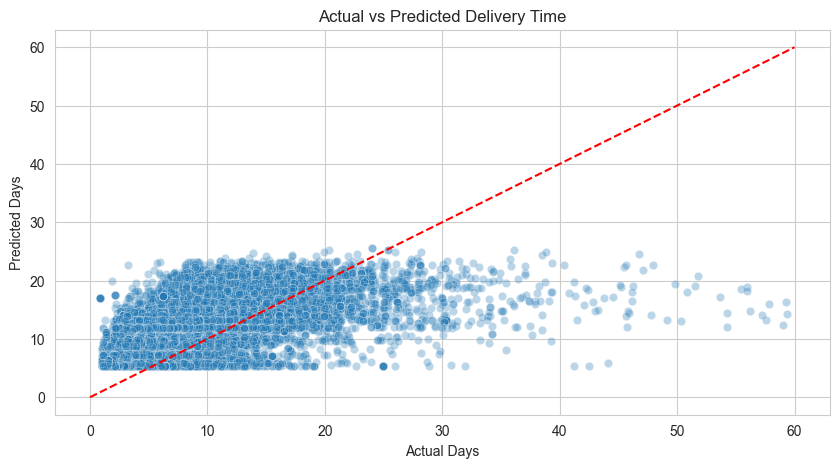

In [13]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=preds, alpha=0.3)
plt.plot([0, 60], [0, 60], color='red', linestyle='--')
plt.xlabel("Actual Days")
plt.ylabel("Predicted Days")
plt.title("Actual vs Predicted Delivery Time")
plt.show()

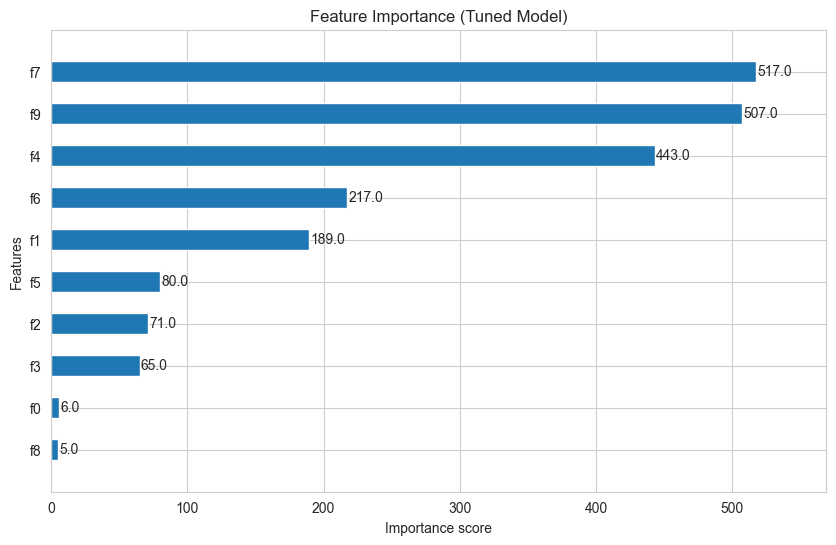

In [14]:
xgb.plot_importance(best_model, max_num_features=12, height=0.5)
plt.title("Feature Importance (Tuned Model)")
plt.show()